# Track Record
Dieses Notebook dient dazu, die Performance eines Forecast am Markt für die letzten 8 Jahre zu ermitteln. Dazu gelten folgende Regeln:
- Startbudget: 10.000€
- Ein Kauf/Verkauf pro Monat
- Vorhersagen werden am Anfang des Jahres unter Einbezug aller vorherigen Daten als Kontext gemacht.

In [21]:
# Imports
import pandas as pd
from track_record_helpers import get_df_from_Sample_Forecast

In [22]:
# Import forecasts and get single time series from it.
forecasting_strategy = "yearly re-training" # or "single training"

if forecasting_strategy == "single training":
    forecast_list = pd.read_pickle('../modelling/backtests/8_windows/v5/8year_test_forecasts.pkl')
    forecast_df = pd.DataFrame()

    for forecast in forecast_list:
        df = get_df_from_Sample_Forecast(forecast)
        forecast_df = pd.concat((forecast_df, df), axis=0)
elif forecasting_strategy == "yearly re-training":
    num_forecasts = 6
    forecasts = [pd.read_pickle(f'../modelling/backtests/individual_model_backtests/individual_test_{i}_forecast.pkl') for i in range(1, num_forecasts + 1)]
    forecast_df = pd.DataFrame()

    for forecast_list in forecasts:
        for forecast in forecast_list:
            df = get_df_from_Sample_Forecast(forecast)
            forecast_df = pd.concat((forecast_df, df), axis=0)

    forecast_df.sort_index(inplace=True)

else:
    print("CAUTION: Please choose one of the forecasting strategies: \nsingle training or yearly re-training!")

forecast_df['forecast_mean'] = forecast_df.mean(axis=1)
forecast_df.drop(axis=1, columns=list(range(100)), inplace=True)
forecast_df.head(450)

,forecast_mean
2016-12-19,2228.726074
2016-12-26,2214.427979
2017-01-02,2186.843018
2017-01-09,2199.468994
2017-01-16,2175.827393
...,...
2023-04-24,4723.347168
2023-05-01,4745.948730
2023-05-08,4780.168457
2023-05-15,4786.772461


In [23]:
# Import the actual time series
indices_df = pd.read_csv('./financial_ts/indices.csv', index_col=0)
snp_series = indices_df['S&P']
snp_series

1971-02-08        NaN
1971-02-15        NaN
1971-02-22        NaN
1971-03-01        NaN
1971-03-08        NaN
               ...   
2023-04-24    4132.07
2023-05-01    4166.79
2023-05-08    4136.98
2023-05-15    4126.65
2023-05-22    4190.78
Name: S&P, Length: 2729, dtype: float64

In [24]:
# Set input parameters for the track record calculation
budget = 10000
risk_factor = 1
trading_interval = 4

# Calculate track record
track_record = pd.DataFrame(columns=['Date', 'Action', 'Forecast', 'Actual', 'Return (%)', 'Budget', 'LongOnly'])
track_record['Date'] = forecast_df.index
track_record['Forecast'] = forecast_df['forecast_mean'].values
track_record['Actual'] = snp_series.values[-forecast_df.shape[0]:]

# Set the LongOnly strategy column
norm_factor = track_record.at[0, 'Actual'] / budget
track_record['LongOnly'] = track_record['Actual'] / norm_factor

# Calculate monthly returns and track record
for i in range(0, len(track_record), trading_interval):

    # Get the forecasted movemnt within the next 4 weeks
    forecasted_change = (track_record['Forecast'].iloc[i + trading_interval- 1] - track_record['Forecast'].iloc[i]) / track_record['Forecast'].iloc[i]
    actual_change = (track_record['Actual'].iloc[i + trading_interval - 1] - track_record['Actual'].iloc[i]) / track_record['Actual'].iloc[i]
    actual_change = 0 if pd.isna(actual_change) else actual_change # Do not trade when index data is missing

    # print(f"Index {i}: \nForecasted Change: {forecasted_change} \nActual Change: {actual_change}")

    if forecasted_change > 0:
        action = 'Buy'
        budget *= (1 + risk_factor * actual_change)
    else:
        action = 'Sell'
        budget *= (1 - risk_factor * actual_change)
    
    action = 'Nothing' if actual_change == 0 else action

    # Update the track record DataFrame
    track_record.at[i, 'Action'] = action
    track_record.at[i, 'Return (%)'] = actual_change
    track_record.at[i, 'Budget'] = budget

# Print the track record
track_record.to_csv('../documentation/track_record.csv', index=False)
print(track_record.head(420))

          Date Action     Forecast   Actual Return (%)        Budget   
0   2016-12-19   Sell  2228.726074  2259.24   0.006352   9936.483065  \
1   2016-12-26    NaN  2214.427979  2260.25        NaN           NaN   
2   2017-01-02    NaN  2186.843018  2251.61        NaN           NaN   
3   2017-01-09    NaN  2199.468994  2273.59        NaN           NaN   
4   2017-01-16   Sell  2175.827393  2272.74   0.009478   9842.309581   
..         ...    ...          ...      ...        ...           ...   
331 2023-04-24    NaN  4723.347168  4132.07        NaN           NaN   
332 2023-05-01    Buy  4745.948730  4166.79   0.005757  12355.465722   
333 2023-05-08    NaN  4780.168457  4136.98        NaN           NaN   
334 2023-05-15    NaN  4786.772461  4126.65        NaN           NaN   
335 2023-05-22    NaN  4815.961426  4190.78        NaN           NaN   

         LongOnly  
0    10000.000000  
1    10004.470530  
2     9966.227581  
3    10063.516935  
4    10059.754608  
..            .

## Track record analysis
Further analysis on top of the track record

In [17]:
import matplotlib.pyplot as plt

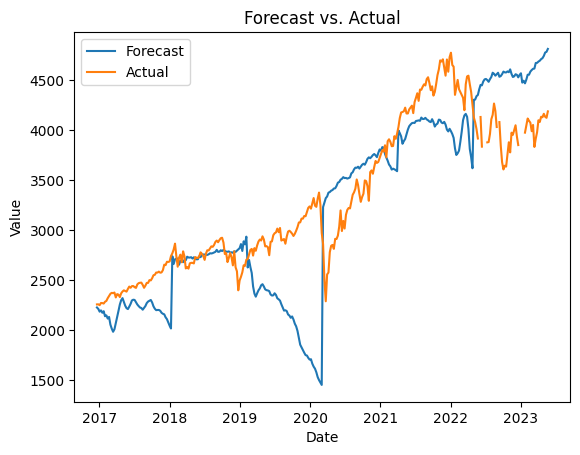

In [18]:
# Forecasted S&P 500 vs actual index data
plt.plot(track_record['Date'], track_record['Forecast'], label='Forecast')
plt.plot(track_record['Date'], track_record['Actual'], label='Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs. Actual')
plt.legend()
plt.show()

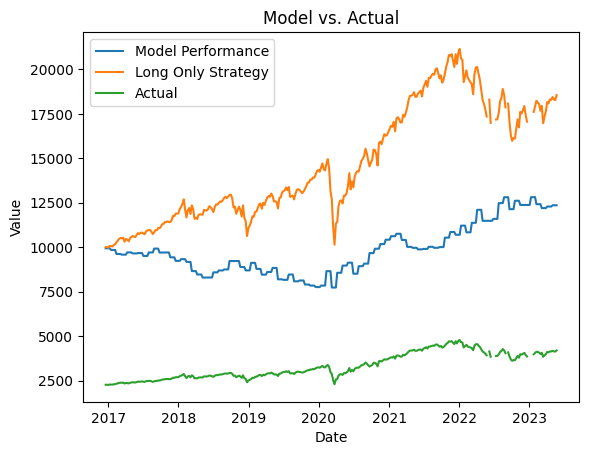

In [29]:
# Plot the models track record vs. a long only strategy (just investing once in the beginning).
plt.plot(track_record['Date'], track_record['Budget'].interpolate(method='pad'), label='Model Performance')
plt.plot(track_record['Date'], track_record['LongOnly'], label='Long Only Strategy')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Model vs. Index value')
plt.legend()
plt.show()

In [20]:
print(f"Value counts for the actions: \n{track_record['Action'].value_counts()}")

Value counts for the actions: 
Action
Sell       44
Buy        38
Nothing     2
Name: count, dtype: int64
